In [ ]:
# %pip install pandas numpy scikit-learn torch torchsummary matplotlib

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm.notebook import tqdm

# Check if GPU is available and set device accordingly
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")


In [5]:

# Load the dataset
file_path = 'q1_filtered_dataset.csv'
data = pd.read_csv(file_path)

# Select relevant columns
data = data[['date', 'open', 'high', 'low', 'close', 'volume']]

# Convert date to datetime and set it as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Convert to PyTorch tensors
sequence_length = 60  # Use 60 minutes of data to predict the next time step
close_index = data.columns.get_loc('close')  # Get the index of the 'close' column

def create_sequences(data, seq_length, target_index):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length, target_index]  # Use 'close' price as the target
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X, y = create_sequences(data_scaled, sequence_length, close_index)
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1).to(device)

# Create DataLoader
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)



In [6]:
class StockPredictor(nn.Module):
    def __init__(self, input_dim, embedding_dim, nhead, num_layers):
        super(StockPredictor, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # Transpose to match the expected input shape for the Transformer (seq_len, batch_size, embedding_dim)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # Transpose back to (batch_size, seq_len, embedding_dim)
        x = x[:, -1, :]  # Use the output of the last time step
        x = self.fc(x)
        return x

# Initialize the model on CPU for summary
input_dim = X_tensor.shape[2]  # Updated input dimension
embedding_dim = 512
nhead = 8
num_layers = 6
model_cpu = StockPredictor(input_dim, embedding_dim, nhead, num_layers).to("cpu")

# Manually create a dummy input tensor and pass it through the model
dummy_input = torch.randn(1, sequence_length, input_dim).to("cpu")  # (batch_size, sequence_length, input_dim)
model_cpu(dummy_input)  # This should now work without errors

# Print model summary manually
print(model_cpu)


StockPredictor(
  (embedding): Linear(in_features=5, out_features=512, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=2048, bias

In [7]:

# Move the model to the original device for training
model = StockPredictor(input_dim, embedding_dim, nhead, num_layers).to(device)

# Training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            X_batch, y_batch = batch
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}")

def evaluate_model(model, data_loader, criterion):
    model.eval()
    losses = []
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            X_batch, y_batch = batch
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            losses.append(loss.item())
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
    return np.mean(losses), np.array(all_predictions), np.array(all_targets)

# Initialize training components
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
num_epochs = 10



In [8]:
# Train the model
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 1, Loss: 0.05024153955150647


Epoch 2/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 2, Loss: 0.003009833491709936


Epoch 3/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 3, Loss: 0.0017446113418339304


Epoch 4/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 4, Loss: 0.0012386828249493639


Epoch 5/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 5, Loss: 0.000965162829957708


Epoch 6/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 6, Loss: 0.0007897768523297132


Epoch 7/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 7, Loss: 0.0007572819878179063


Epoch 8/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 8, Loss: 0.0006027998477336167


Epoch 9/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 9, Loss: 0.0006771385822576856


Epoch 10/10:   0%|          | 0/594 [00:00<?, ?it/s]

Epoch 10, Loss: 0.0005838407908931025


In [9]:

# Evaluate the model
train_loss, train_preds, train_targets = evaluate_model(model, train_loader, criterion)
val_loss, val_preds, val_targets = evaluate_model(model, val_loader, criterion)

print(f'Train Loss: {train_loss}')
print(f'Validation Loss: {val_loss}')



Evaluating:   0%|          | 0/594 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/149 [00:00<?, ?it/s]

Train Loss: 0.0002686298668520223
Validation Loss: 0.0002922039965773939


In [10]:
# Calculate performance metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Calculate and print metrics
train_mae, train_mse, train_rmse, train_r2 = calculate_metrics(train_targets, train_preds)
val_mae, val_mse, val_rmse, val_r2 = calculate_metrics(val_targets, val_preds)

print(f'Train MAE: {train_mae}, Train MSE: {train_mse}, Train RMSE: {train_rmse}, Train R2: {train_r2}')
print(f'Validation MAE: {val_mae}, Validation MSE: {val_mse}, Validation RMSE: {val_rmse}, Validation R2: {val_r2}')


Train MAE: 0.007563580293208361, Train MSE: 0.0002689234970603138, Train RMSE: 0.01639888621866703, Train R2: 0.9932159463818712
Validation MAE: 0.0075965337455272675, Validation MSE: 0.00029343896312639117, Validation RMSE: 0.017130060121417046, Validation R2: 0.9926208363578365


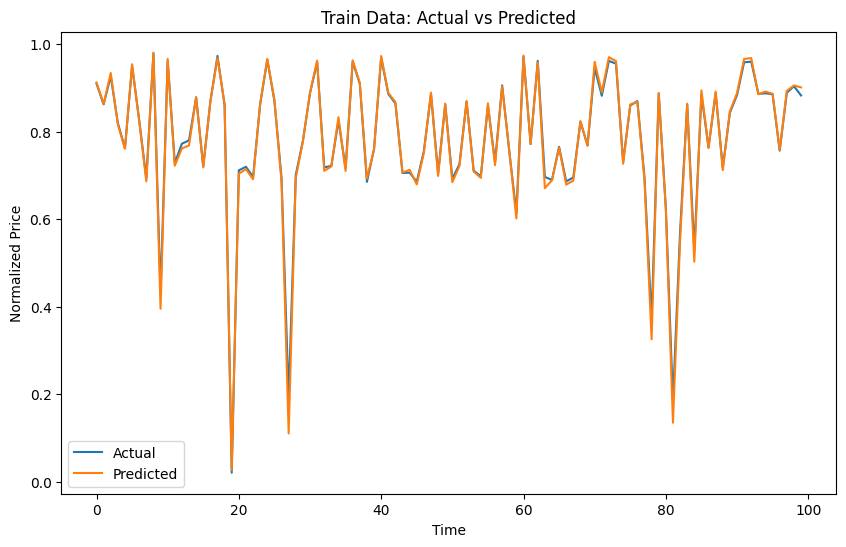

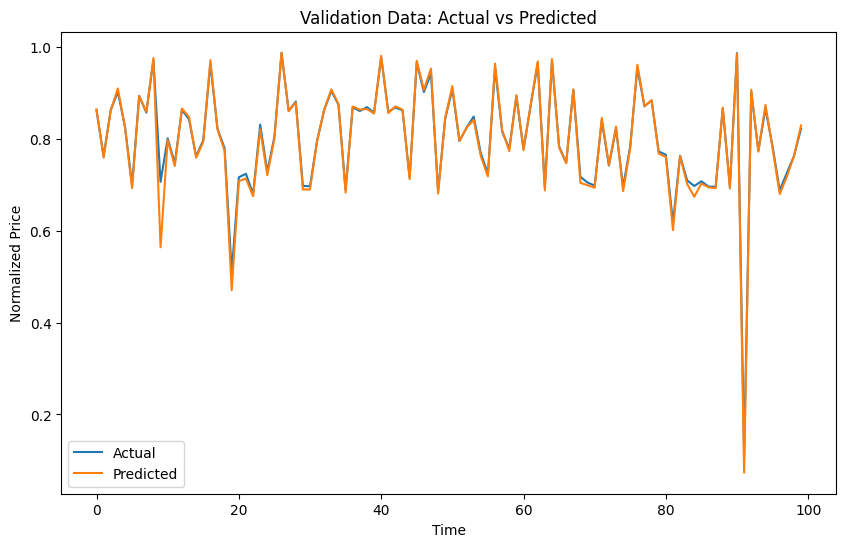

In [12]:
# Plot predictions vs targets
def plot_predictions(targets, predictions, title, start=0, end=1000):
    plt.figure(figsize=(10, 6))
    plt.plot(targets[start:end], label='Actual')
    plt.plot(predictions[start:end], label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()

# Plot a smaller time window for better visualization
plot_predictions(train_targets, train_preds, 'Train Data: Actual vs Predicted', start=0, end=100)
plot_predictions(val_targets, val_preds, 'Validation Data: Actual vs Predicted', start=0, end=100)


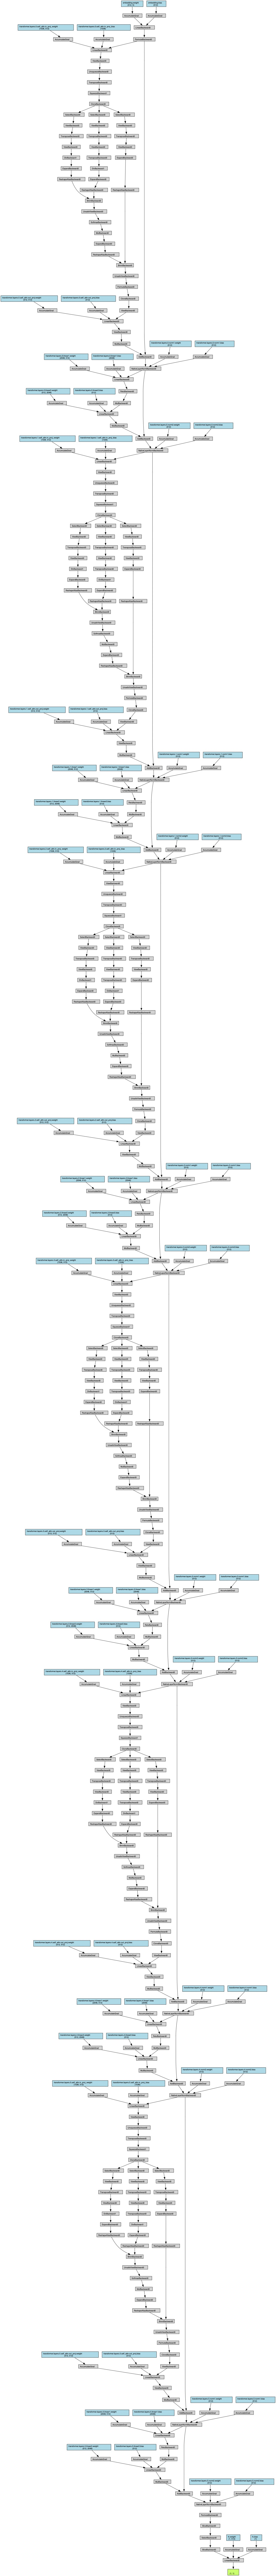

In [13]:

# Visualing the model with torchviz
# %pip install torchviz

import torch
from torchviz import make_dot

# Define a simple dummy input tensor with the correct shape
dummy_input = torch.randn(1, sequence_length, input_dim).to(device)

# Forward pass through the model to create the computational graph
model = StockPredictor(input_dim, embedding_dim, nhead, num_layers).to(device)
output = model(dummy_input)

# Generate a graph of the model
model_graph = make_dot(output, params=dict(model.named_parameters()))

# Save the graph to a file
model_graph.format = 'jpeg'
model_graph.render('model_graph')

# Display the graph
from IPython.display import Image
Image(filename='model_graph.jpeg')

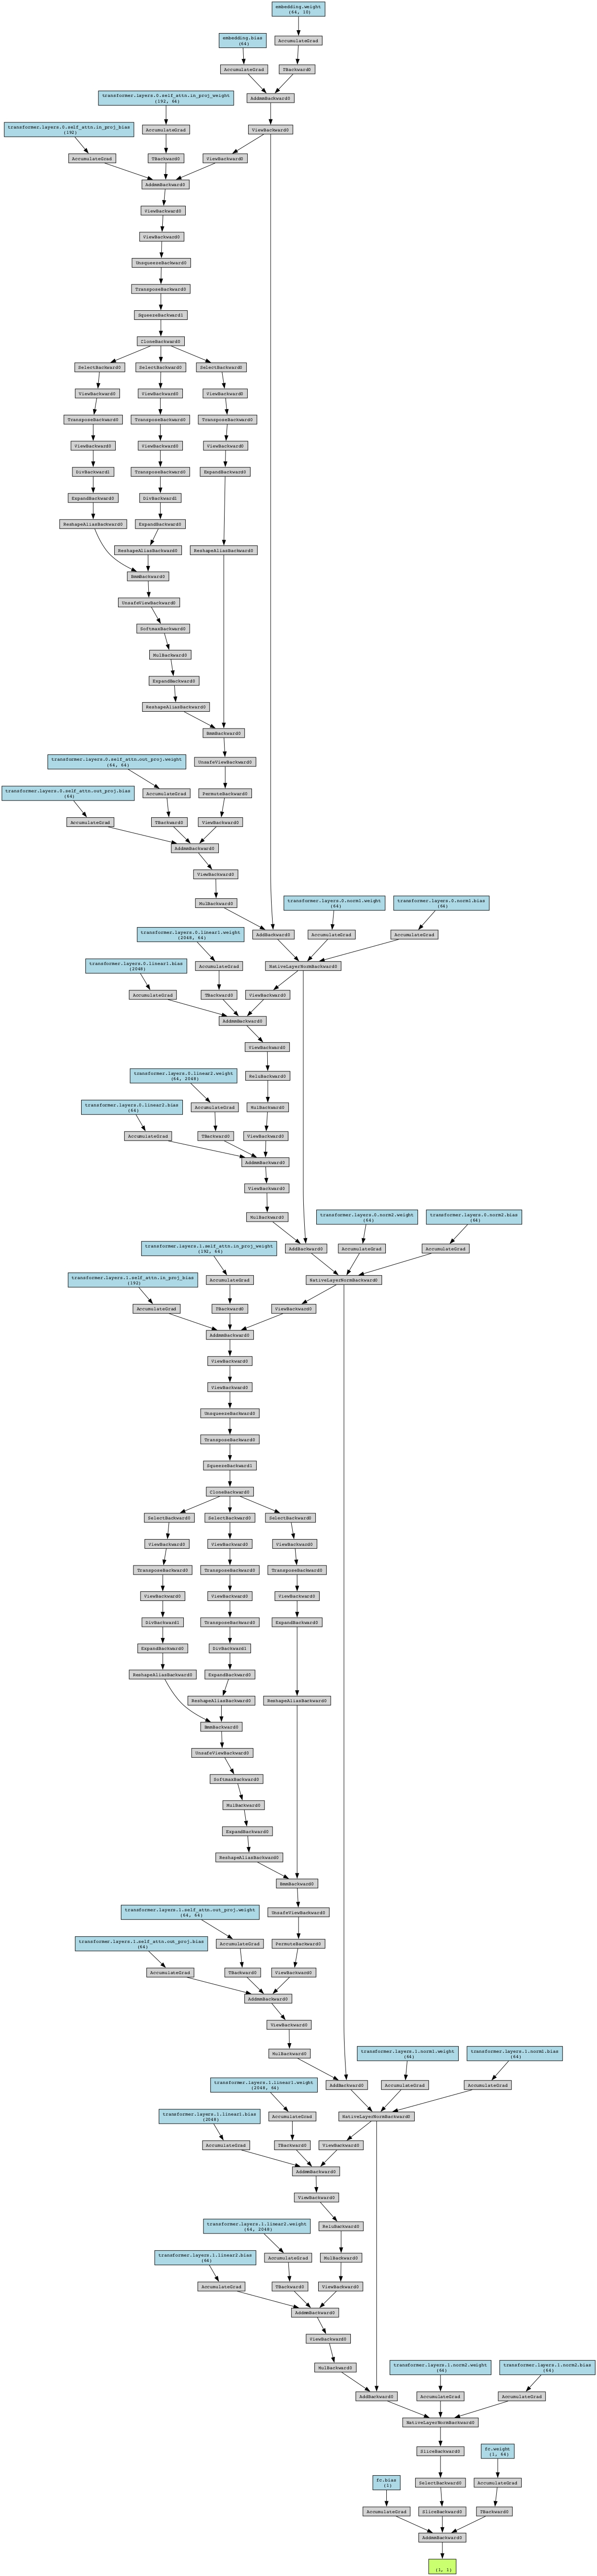

In [14]:


import torch
from torchviz import make_dot
from torchinfo import summary
from PIL import Image

# Define a simplified version of your model for better visualization
class SimpleStockPredictor(nn.Module):
    def __init__(self, input_dim, embedding_dim, nhead, num_layers):
        super(SimpleStockPredictor, self).__init__()
        self.embedding = nn.Linear(input_dim, embedding_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x[:, -1, :]  # Use the output of the last time step
        x = self.fc(x)
        return x

# Reduce the number of layers and heads for visualization
input_dim = 10  # Reduced input dimension for simplicity
embedding_dim = 64
nhead = 4
num_layers = 2
simplified_model = SimpleStockPredictor(input_dim, embedding_dim, nhead, num_layers).to("cpu")

# Create a dummy input with reduced size
dummy_input = torch.randn(1, sequence_length, input_dim).to("cpu")

# Print model summary on CPU
summary(simplified_model, input_size=(1, sequence_length, input_dim))

# Forward pass through the simplified model to create the computational graph
output = simplified_model(dummy_input)

# Generate a graph of the simplified model
simplified_model_graph = make_dot(output, params=dict(simplified_model.named_parameters()))

# Save the graph to a file
simplified_model_graph.format = 'png'
simplified_model_graph.render('simplified_model_graph')

# Convert the saved PNG file to a high-resolution JPEG
image = Image.open('simplified_model_graph.png')
image = image.convert('RGB')
image.save('simplified_model_graph_high_res.jpeg', 'JPEG', quality=100, dpi=(300, 300))

# Display the high-resolution graph
from IPython.display import Image as IPyImage
IPyImage(filename='simplified_model_graph_high_res.jpeg')